# UNReLo Weather-Forecasting Model
This is a custom model created to forecast weather elements i.e humidity and temperature using weather data collected for over 5 years

Import packages

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error,mean_absolute_error
import joblib
import xgboost as xgb
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor


import warnings
warnings.filterwarnings('ignore')

Load data from the CSV file

In [40]:
nakuru_weather = pd.read_csv("data/TA00026.csv")
nyeri_weather = pd.read_csv("data/TA00283.csv")
kisumu_weather = pd.read_csv("data/TA00146.csv")
turkana_weather = pd.read_csv("data/TA00354.csv")

In [41]:
kisumu_weather = kisumu_weather.assign(location=1)
nyeri_weather = nyeri_weather.assign(location=2)
nakuru_weather = nakuru_weather.assign(location=3)
turkana_weather = turkana_weather.assign(location=4)

In [42]:
weather = pd.concat([nakuru_weather[['timestamp (UTC)','location','temperature AVG (degrees Celsius)', 'relativehumidity AVG (-)']],
                     turkana_weather[['timestamp (UTC)','location','temperature AVG (degrees Celsius)', 'relativehumidity AVG (-)']],
                     kisumu_weather[['timestamp (UTC)','location','temperature S001356 AVG (degrees Celsius)', 'relativehumidity S001356 AVG (-)']],
                     nyeri_weather[['timestamp (UTC)','location','temperature AVG (degrees Celsius)', 'relativehumidity AVG (-)']]],
                    axis=0)

weather['avg_humidity'] = weather['relativehumidity AVG (-)'].combine_first(weather['relativehumidity S001356 AVG (-)'])
weather.drop(['relativehumidity AVG (-)', 'relativehumidity S001356 AVG (-)'], axis=1, inplace=True)

weather['avg_temp'] = weather['temperature AVG (degrees Celsius)'].combine_first(weather['temperature S001356 AVG (degrees Celsius)'])
weather.drop(['temperature AVG (degrees Celsius)', 'temperature S001356 AVG (degrees Celsius)'], axis=1, inplace=True)

weather.columns = ['timestamp (UTC)','sensor_id', 'avg_humidity','avg_temp']
weather

,timestamp (UTC),sensor_id,avg_humidity,avg_temp
0,2018-01-01 00:00,3,0.728333,13.166667
1,2018-01-01 01:00,3,0.785000,11.925000
2,2018-01-01 02:00,3,0.819167,11.041667
3,2018-01-01 03:00,3,0.853333,10.333333
4,2018-01-01 04:00,3,0.805833,12.633333
...,...,...,...,...
43819,2022-12-31 19:00,2,0.708333,16.533333
43820,2022-12-31 20:00,2,0.743917,14.941667
43821,2022-12-31 21:00,2,0.819417,12.458333
43822,2022-12-31 22:00,2,0.865667,10.191667


# Exploratory Data Analysis

In [43]:
print(weather.shape)
weather.describe()

(174792, 4)


,sensor_id,avg_humidity,avg_temp
count,174792.000000,155843.000000,155868.000000
mean,2.495675,0.697478,21.962936
std,1.116739,0.202164,6.545789
min,1.000000,0.081417,2.625000
25%,1.000000,0.535500,16.466667
50%,2.000000,0.728583,21.525000
75%,3.000000,0.871000,26.841667
max,4.000000,1.000000,39.491667


In [44]:
weather.head()

,timestamp (UTC),sensor_id,avg_humidity,avg_temp
0,2018-01-01 00:00,3,0.728333,13.166667
1,2018-01-01 01:00,3,0.785000,11.925000
2,2018-01-01 02:00,3,0.819167,11.041667
3,2018-01-01 03:00,3,0.853333,10.333333
4,2018-01-01 04:00,3,0.805833,12.633333


Check for null/missing values

In [45]:
weather.apply(pd.isnull).sum()/weather.shape[0]

timestamp (UTC)    0.000000
sensor_id          0.000000
avg_humidity       0.108409
avg_temp           0.108266
dtype: float64

Deal with missing values

In [46]:
#fill with previous value
weather=weather.fillna(method='ffill')
weather.apply(pd.isnull).sum()/weather.shape[0]

timestamp (UTC)    0.0
sensor_id          0.0
avg_humidity       0.0
avg_temp           0.0
dtype: float64

Checking for outliers

In [47]:
def outlier_thresholds(dataframe, col_name, q1_perc=0.05, q3_perc=0.95):
    
    quartile1 = dataframe[col_name].quantile(q1_perc)
    quartile3 = dataframe[col_name].quantile(q3_perc)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit


def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name, q1_perc=0.01, q3_perc=0.99)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True

    else:
        return False

check_outlier(weather,['avg_temp','avg_humidity'])

False

Make sure we have correct data types

In [48]:
#convert index type to datetime
weather['timestamp (UTC)']=pd.to_datetime(weather['timestamp (UTC)'])
weather.dtypes

timestamp (UTC)    datetime64[ns]
sensor_id                   int64
avg_humidity              float64
avg_temp                  float64
dtype: object

Visualize the data 

<Axes: >

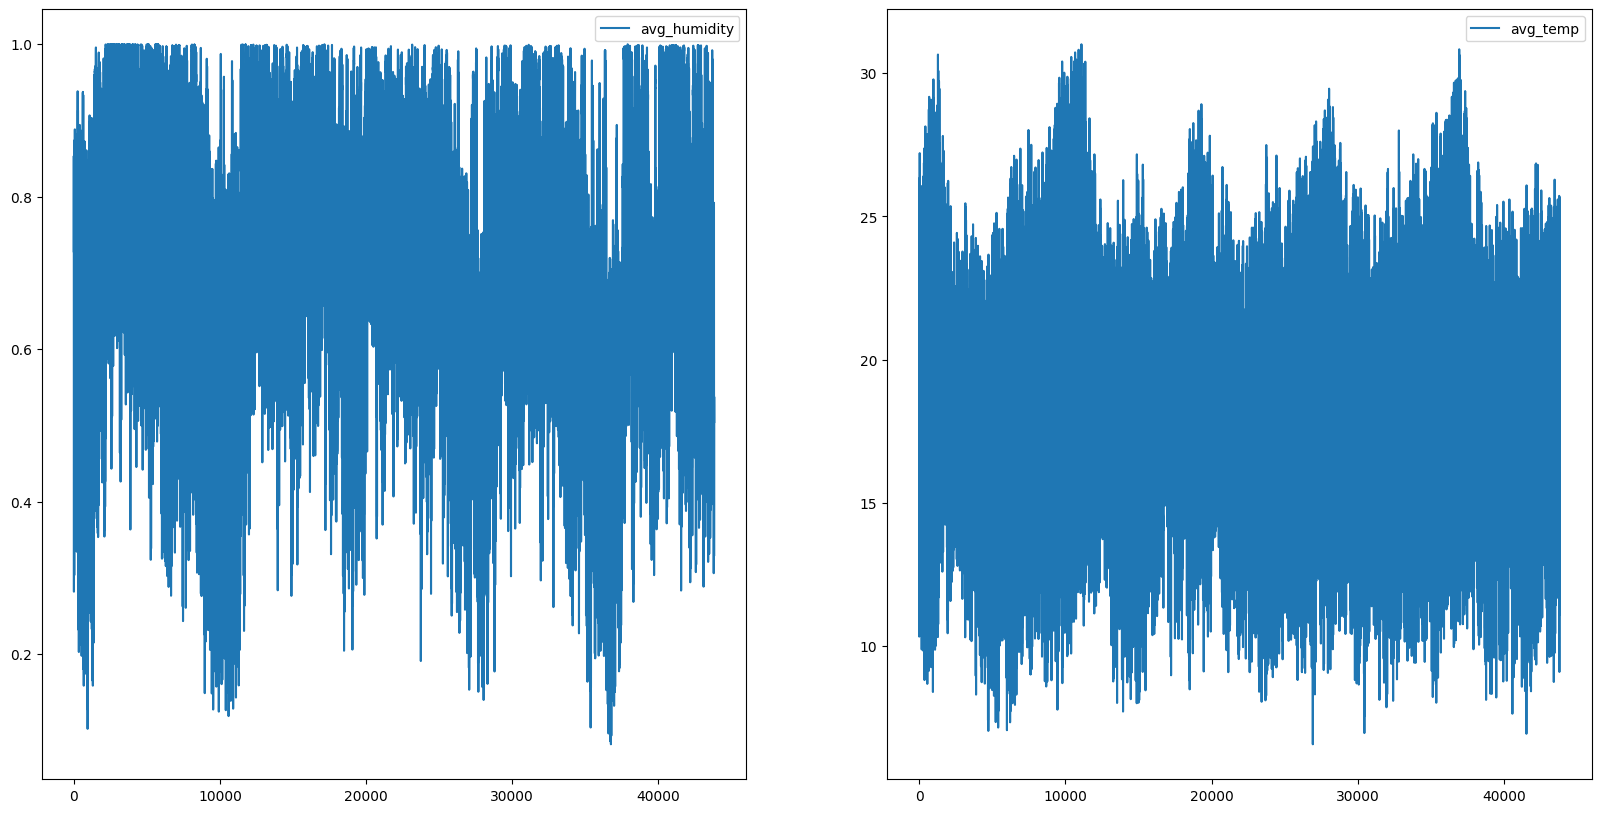

In [49]:
fig, ax = plt.subplots(1,2,figsize=(20,10))
weather[['avg_humidity']].loc[weather['sensor_id'] == 3].plot(ax=ax[0])
weather[['avg_temp']].loc[weather['sensor_id'] == 3].plot(ax=ax[1])

See the trend and nature of data

<Axes: xlabel='timestamp (UTC)'>

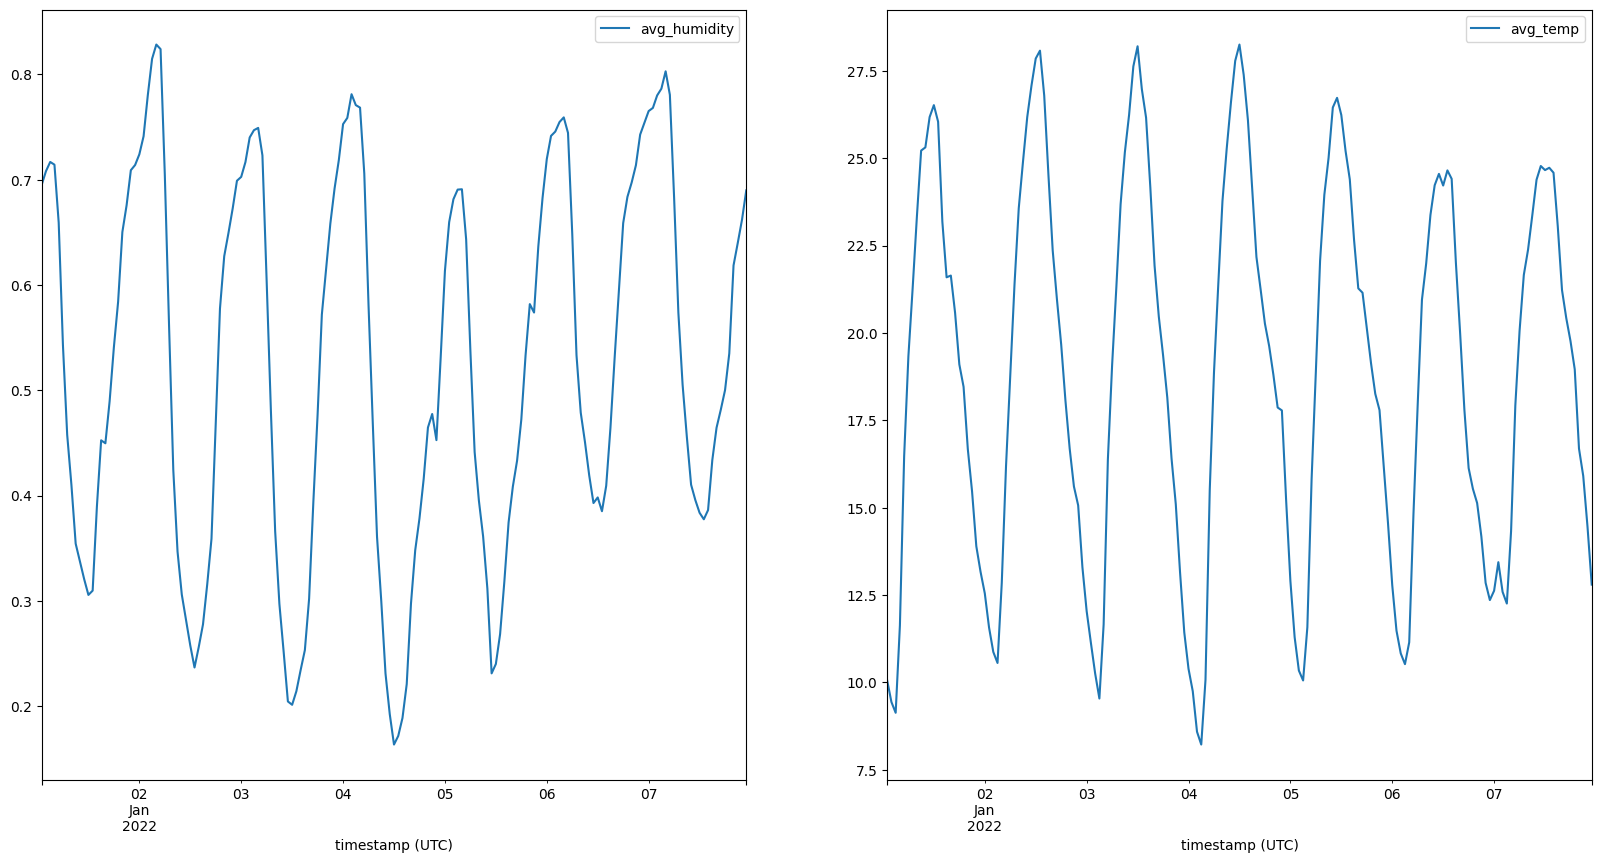

In [50]:
fig, ax = plt.subplots(1,2,figsize=(20,10))
weather.loc[(weather['timestamp (UTC)']>'2022-01-01')&(weather['timestamp (UTC)']<'2022-01-08')&(weather['sensor_id']==3)].plot(x='timestamp (UTC)',y='avg_humidity',figsize=(20,10),ax=ax[0])
weather.loc[(weather['timestamp (UTC)']>'2022-01-01')&(weather['timestamp (UTC)']<'2022-01-08')&(weather['sensor_id']==3)].plot(x='timestamp (UTC)',y='avg_temp',figsize=(20,10),ax=ax[1])

Feature engineering

In [52]:
def create_features(weather):
    weather = weather.copy()
    weather['timestamp (UTC)'] = pd.to_datetime(weather['timestamp (UTC)'])
    weather['hour'] = weather['timestamp (UTC)'].dt.hour
    weather['dayofweek'] = weather['timestamp (UTC)'].dt.dayofweek
    weather['quarter'] = weather['timestamp (UTC)'].dt.quarter
    weather['month'] = weather['timestamp (UTC)'].dt.month
    weather['year'] = weather['timestamp (UTC)'].dt.year
    weather['dayofyear'] = weather['timestamp (UTC)'].dt.dayofyear
    return weather

weather = create_features(weather)
weather

,timestamp (UTC),sensor_id,avg_humidity,avg_temp,hour,dayofweek,quarter,month,year,dayofyear
0,2018-01-01 00:00:00,3,0.728333,13.166667,0,0,1,1,2018,1
1,2018-01-01 01:00:00,3,0.785000,11.925000,1,0,1,1,2018,1
2,2018-01-01 02:00:00,3,0.819167,11.041667,2,0,1,1,2018,1
3,2018-01-01 03:00:00,3,0.853333,10.333333,3,0,1,1,2018,1
4,2018-01-01 04:00:00,3,0.805833,12.633333,4,0,1,1,2018,1
...,...,...,...,...,...,...,...,...,...,...
43819,2022-12-31 19:00:00,2,0.708333,16.533333,19,5,4,12,2022,365
43820,2022-12-31 20:00:00,2,0.743917,14.941667,20,5,4,12,2022,365
43821,2022-12-31 21:00:00,2,0.819417,12.458333,21,5,4,12,2022,365
43822,2022-12-31 22:00:00,2,0.865667,10.191667,22,5,4,12,2022,365


# Train-Validation Split

In [53]:
train=weather.loc[weather['timestamp (UTC)']<'2022-01-01']
test=weather.loc[weather['timestamp (UTC)']>='2022-01-01']
train.shape,test.shape

((139752, 10), (35040, 10))

<Axes: >

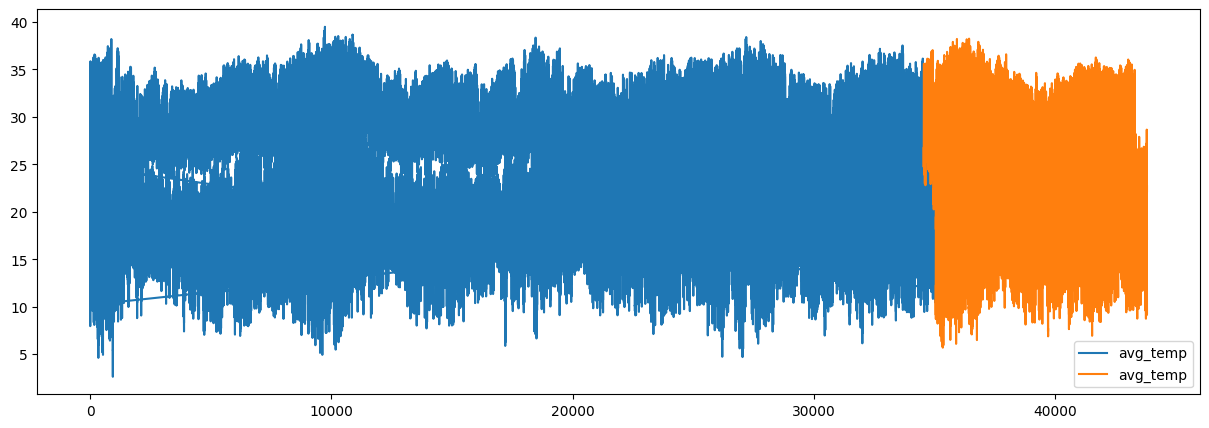

In [54]:
#drop last row since it has no target
fig, ax=plt.subplots(figsize=(15,5))
train[['avg_temp']].plot(ax=ax)
test[['avg_temp']].plot(ax=ax)

<Axes: >

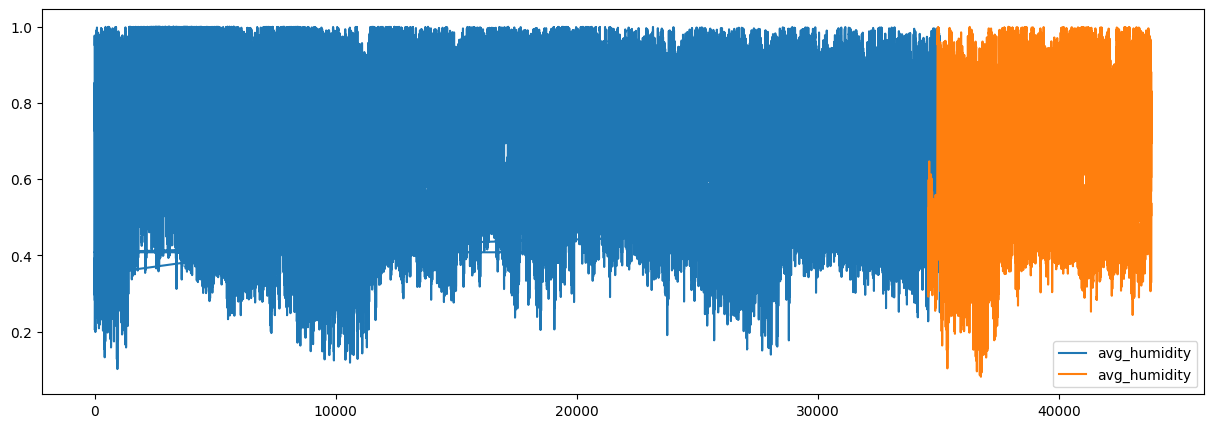

In [55]:
fig, ax=plt.subplots(figsize=(15,5))
train[['avg_humidity']].plot(ax=ax)
test[['avg_humidity']].plot(ax=ax)

In [69]:
train=create_features(train)
test=create_features(test)
features=['dayofweek','quarter','month','year','dayofyear','hour','sensor_id']
target=['avg_temp','avg_humidity']
time=['timestamp (UTC)']

In [71]:
X_train=train[features]
y_train=train[target]

X_test=test[features]
y_test=test[target]
y_test_time=test[time]

# Create the model

Using CatBoost Regressor

In [58]:
cat_model = CatBoostRegressor(n_estimators=1000,early_stopping_rounds=50,learning_rate=0.01,loss_function='MultiRMSE')
cat_model.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_test,y_test)],verbose=100)

cat_pred = cat_model.predict(X_test)

print("Mean squared error on testing data: {:.4f}".format(mean_squared_error(y_test,cat_pred)))
print("Mean absolute error on testing data: {:.4f}".format(mean_absolute_error(y_test,cat_pred)))
print("Mean absolute percentage error on testing data: {:.4f}".format(np.mean(np.abs((y_test - cat_pred) / y_test)) * 100))

0:	learn: 6.3367791	test: 6.3367791	test1: 6.3314555	best: 6.3314555 (0)	total: 165ms	remaining: 2m 44s
100:	learn: 3.0731524	test: 3.0731524	test1: 3.1875021	best: 3.1875021 (100)	total: 2.91s	remaining: 25.9s
200:	learn: 2.1828872	test: 2.1828872	test1: 2.3213766	best: 2.3213766 (200)	total: 5.46s	remaining: 21.7s
300:	learn: 1.9510364	test: 1.9510364	test1: 2.0901319	best: 2.0901319 (300)	total: 8.18s	remaining: 19s
400:	learn: 1.8596661	test: 1.8596661	test1: 1.9894436	best: 1.9894436 (400)	total: 12.3s	remaining: 18.3s
500:	learn: 1.8066523	test: 1.8066523	test1: 1.9409602	best: 1.9409602 (500)	total: 16.2s	remaining: 16.1s
600:	learn: 1.7694513	test: 1.7694513	test1: 1.9124865	best: 1.9124865 (600)	total: 19.7s	remaining: 13.1s
700:	learn: 1.7406770	test: 1.7406770	test1: 1.8942567	best: 1.8942567 (700)	total: 23.5s	remaining: 10s
800:	learn: 1.7187168	test: 1.7187168	test1: 1.8810404	best: 1.8810271 (799)	total: 26.9s	remaining: 6.68s
900:	learn: 1.7003666	test: 1.7003666	test1:

Using Random Forest Regressor

In [59]:
rf_model = RandomForestRegressor(n_estimators=1000,random_state=42)
rf_model.fit(X_train,y_train)

rf_pred = rf_model.predict(X_test)


print("Mean squared error on testing data: {:.4f}".format(mean_squared_error(y_test,rf_pred)))
print("Mean absolute error on testing data: {:.4f}".format(mean_absolute_error(y_test,rf_pred)))
print("Mean absolute percentage error on testing data: {:.4f}".format(np.mean(np.abs((y_test - rf_pred) / y_test)) * 100))


Mean squared error on testing data: 2.3715
Mean absolute error on testing data: 0.8317
Mean absolute percentage error on testing data: 11.1371


Using XGBOOST Regressor

In [60]:
reg= xgb.XGBRegressor(n_estimators=1000,early_stopping_rounds=50,learning_rate=0.01)
reg.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_test,y_test)],verbose=100)

predictions=reg.predict(X_test)

print("Mean squared error on testing data: {:.4f}".format(mean_squared_error(y_test,predictions)))
print("Mean absolute error on testing data: {:.4f}".format(mean_absolute_error(y_test,predictions)))
print("Mean absolute percentage error on testing data: {:.4f}".format(np.mean(np.abs((y_test - predictions) / y_test)) * 100))



[0]	validation_0-rmse:16.09033	validation_1-rmse:15.84113
[100]	validation_0-rmse:6.02848	validation_1-rmse:5.99908
[200]	validation_0-rmse:2.51617	validation_1-rmse:2.56818
[300]	validation_0-rmse:1.47554	validation_1-rmse:1.55973
[400]	validation_0-rmse:1.22445	validation_1-rmse:1.34704
[500]	validation_0-rmse:1.15614	validation_1-rmse:1.30333
[600]	validation_0-rmse:1.12408	validation_1-rmse:1.29868
[630]	validation_0-rmse:1.11791	validation_1-rmse:1.29895
Mean squared error on testing data: 1.6855
Mean absolute error on testing data: 0.7150
Mean absolute percentage error on testing data: 9.7876


Combine the data with prediction

In [76]:
combined=pd.concat([y_test,y_test_time,X_test['sensor_id'],pd.DataFrame(data=predictions,index=y_test.index,columns=['predicted_temp','predicted_humidity'],)],axis=1)
combined.sort_index(inplace=True)
combined

,avg_temp,avg_humidity,timestamp (UTC),sensor_id,predicted_temp,predicted_humidity
34560,26.758333,0.480917,2022-01-01 00:00:00,4,23.976770,0.870169
34561,26.200000,0.487750,2022-01-01 01:00:00,4,23.647713,0.887206
34562,25.025000,0.504500,2022-01-01 02:00:00,4,23.341305,0.908773
34563,24.725000,0.521167,2022-01-01 03:00:00,4,23.148453,0.927930
34564,25.633333,0.521417,2022-01-01 04:00:00,4,23.639154,0.927930
...,...,...,...,...,...,...
43822,17.250000,0.511917,2022-12-31 22:00:00,3,15.037024,0.673542
43822,10.191667,0.865667,2022-12-31 22:00:00,2,14.551783,0.909334
43823,17.058333,0.504333,2022-12-31 23:00:00,3,14.458476,0.686950
43823,22.083333,0.756833,2022-12-31 23:00:00,1,21.640759,0.832189


Feature importance

<Axes: >

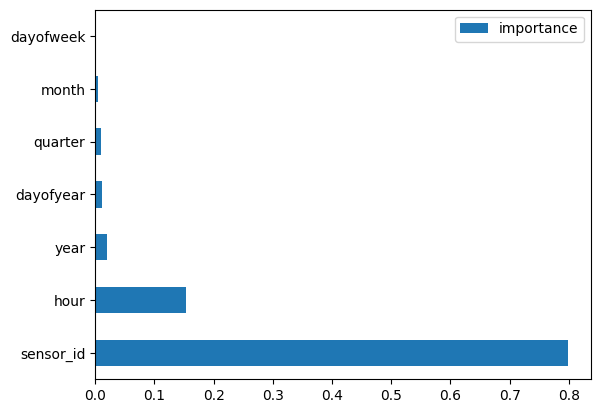

In [77]:
fi=pd.DataFrame(data=reg.feature_importances_,index= reg.feature_names_in_,columns=['importance']).sort_values(by='importance',ascending=False)
fi.plot(kind='barh')

Plot the prediction

<Axes: >

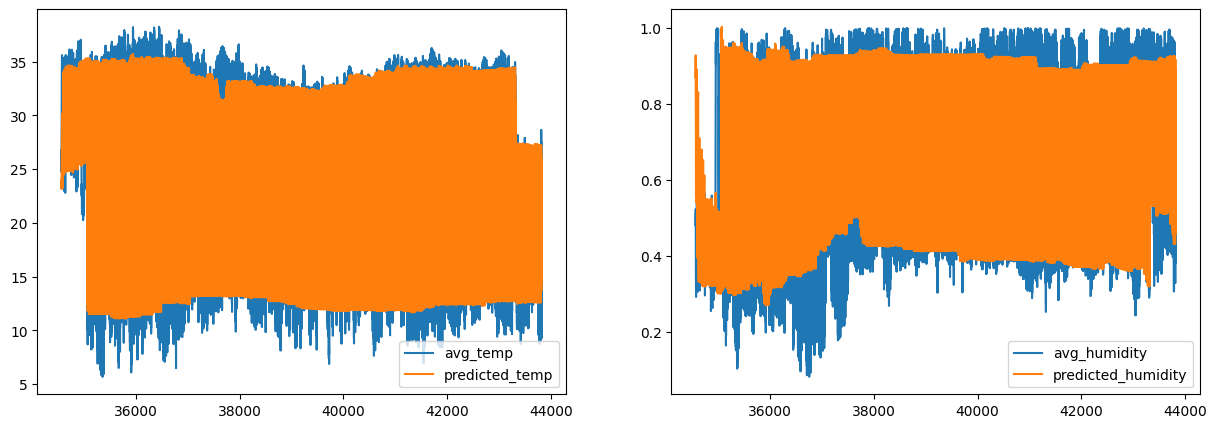

In [78]:
fig,ax=plt.subplots(1,2,figsize=(15,5))
combined[['avg_temp','predicted_temp']].plot(ax=ax[0])
combined[['avg_humidity','predicted_humidity']].plot(ax=ax[1])


<Axes: >

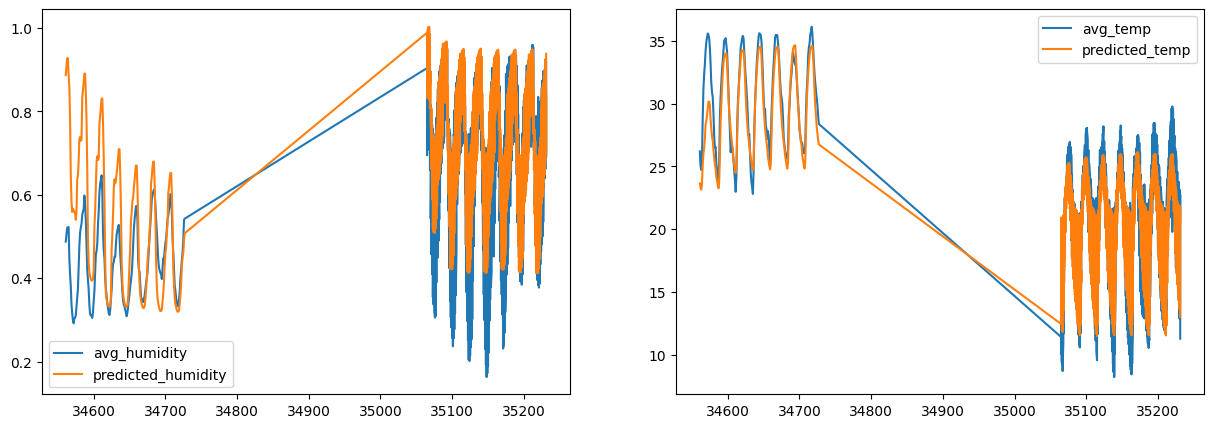

In [79]:
fig, ax=plt.subplots(1,2,figsize=(15,5))
combined.loc[(combined['timestamp (UTC)']>'2022-01-01')&(combined['timestamp (UTC)']<'2022-01-08')][['avg_humidity','predicted_humidity']].plot(ax=ax[0])
combined.loc[(combined['timestamp (UTC)']>'2022-01-01')&(combined['timestamp (UTC)']<'2022-01-08')][['avg_temp','predicted_temp']].plot(ax=ax[1])


# Export the model

In [80]:
joblib.dump(reg, 'reg2.pkl')

['reg2.pkl']

Test

In [117]:
sample = pd.read_csv("sample/sample_1.csv")
sample['timestamp (UTC)']=pd.to_datetime(sample['timestamp (UTC)'])
sample

,timestamp (UTC),avg_temp,avg_humidity,sensor_id
0,2023-01-01 00:00:00,NaN,NaN,3
1,2023-01-01 01:00:00,NaN,NaN,3
2,2023-01-01 02:00:00,NaN,NaN,3
3,2023-01-01 03:00:00,NaN,NaN,3
4,2023-01-01 04:00:00,NaN,NaN,3
...,...,...,...,...
8683,2023-06-30 19:00:00,NaN,NaN,2
8684,2023-06-30 20:00:00,NaN,NaN,2
8685,2023-06-30 21:00:00,NaN,NaN,2
8686,2023-06-30 22:00:00,NaN,NaN,2


In [118]:
sample=create_features(sample)
sample

,timestamp (UTC),avg_temp,avg_humidity,sensor_id,hour,dayofweek,quarter,month,year,dayofyear
0,2023-01-01 00:00:00,NaN,NaN,3,0,6,1,1,2023,1
1,2023-01-01 01:00:00,NaN,NaN,3,1,6,1,1,2023,1
2,2023-01-01 02:00:00,NaN,NaN,3,2,6,1,1,2023,1
3,2023-01-01 03:00:00,NaN,NaN,3,3,6,1,1,2023,1
4,2023-01-01 04:00:00,NaN,NaN,3,4,6,1,1,2023,1
...,...,...,...,...,...,...,...,...,...,...
8683,2023-06-30 19:00:00,NaN,NaN,2,19,4,2,6,2023,181
8684,2023-06-30 20:00:00,NaN,NaN,2,20,4,2,6,2023,181
8685,2023-06-30 21:00:00,NaN,NaN,2,21,4,2,6,2023,181
8686,2023-06-30 22:00:00,NaN,NaN,2,22,4,2,6,2023,181


In [119]:
predictions=reg.predict(sample[features])
sample['avg_temp']=predictions[:,0]
sample['avg_humidity']=predictions[:,1]
sample


,timestamp (UTC),avg_temp,avg_humidity,sensor_id,hour,dayofweek,quarter,month,year,dayofyear
0,2023-01-01 00:00:00,13.652499,0.866792,3,0,6,1,1,2023,1
1,2023-01-01 01:00:00,13.070710,0.885491,3,1,6,1,1,2023,1
2,2023-01-01 02:00:00,12.522349,0.897501,3,2,6,1,1,2023,1
3,2023-01-01 03:00:00,12.335621,0.900341,3,3,6,1,1,2023,1
4,2023-01-01 04:00:00,13.474947,0.901552,3,4,6,1,1,2023,1
...,...,...,...,...,...,...,...,...,...,...
8683,2023-06-30 19:00:00,15.587389,0.851670,2,19,4,2,6,2023,181
8684,2023-06-30 20:00:00,15.214377,0.859932,2,20,4,2,6,2023,181
8685,2023-06-30 21:00:00,14.909657,0.863313,2,21,4,2,6,2023,181
8686,2023-06-30 22:00:00,14.487935,0.877905,2,22,4,2,6,2023,181


In [120]:
combined=pd.concat([weather[['timestamp (UTC)','sensor_id','avg_temp','avg_humidity']],sample[['timestamp (UTC)','sensor_id','avg_temp','avg_humidity']]],axis=0)

# weather['avg_humidity'] = weather['relativehumidity AVG (-)'].combine_first(weather['relativehumidity S001356 AVG (-)'])
# weather.drop(['relativehumidity AVG (-)', 'relativehumidity S001356 AVG (-)'], axis=1, inplace=True)

# weather['avg_temp'] = weather['temperature AVG (degrees Celsius)'].combine_first(weather['temperature S001356 AVG (degrees Celsius)'])
# weather.drop(['temperature AVG (degrees Celsius)', 'temperature S001356 AVG (degrees Celsius)'], axis=1, inplace=True)

combined.sort_index(inplace=True)
combined
# weather[['avg_humidity','avg_temp']]
# predictionsDf[['avg_temp','avg_humidity']]

,timestamp (UTC),sensor_id,avg_temp,avg_humidity
0,2018-01-01 00:00:00,3,13.166667,0.728333
0,2018-01-01 00:00:00,1,27.066667,0.408167
0,2018-01-01 00:00:00,2,10.200000,0.951500
0,2023-01-01 00:00:00,3,13.652499,0.866792
0,2018-01-22 00:00:00,4,24.741667,0.348500
...,...,...,...,...
43822,2022-12-31 22:00:00,3,17.250000,0.511917
43822,2022-12-31 22:00:00,2,10.191667,0.865667
43823,2022-12-31 23:00:00,1,22.083333,0.756833
43823,2022-12-31 23:00:00,2,9.333333,0.879333


<Axes: >

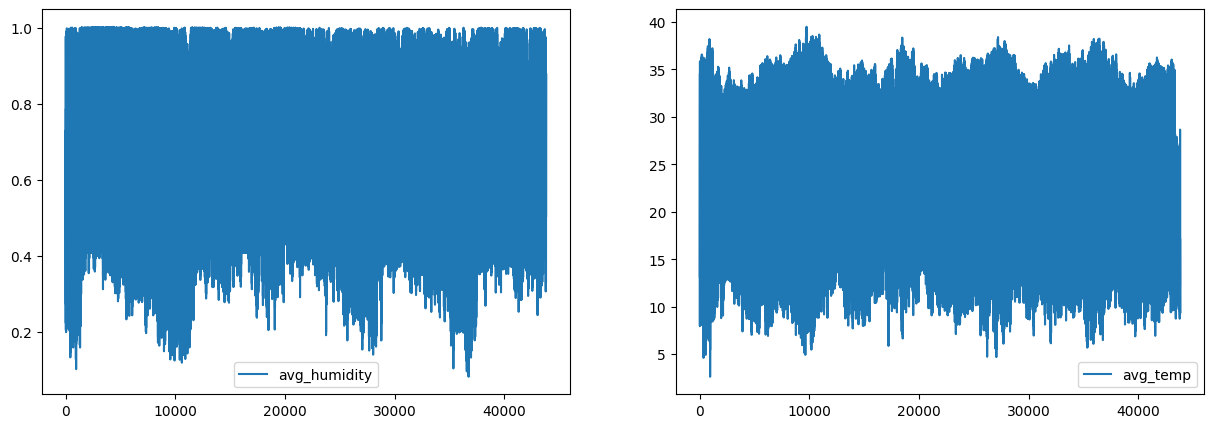

In [121]:
# combined[['avg_humidity','avg_temp']].plot()
fig, ax=plt.subplots(1,2,figsize=(15,5))
combined[['avg_humidity']].plot(ax=ax[0])
combined[['avg_temp']].plot(ax=ax[1])

In [122]:
print(combined.loc[combined['timestamp (UTC)']=='2023-05-18 12:00:00'])

         timestamp (UTC)  sensor_id   avg_temp  avg_humidity
3300 2023-05-18 12:00:00          3  22.209486      0.599694
7644 2023-05-18 12:00:00          2  21.465826      0.752465


In [115]:
import pickle

def forectast(df):
    df.index=pd.to_datetime(df.index)
    df=create_features(df)
    loaded_model = pickle.load(open('reg2.pkl', 'rb'))
    predictions = loaded_model.predict(df[features])
    df['avg_temp']=predictions[:,0]
    df['avg_humidity']=predictions[:,1]
    return df[['avg_temp','avg_humidity']]

forectast(sample)

,avg_temp,avg_humidity
1970-01-01 00:00:00.000000000,13.652499,0.866792
1970-01-01 00:00:00.000000001,13.070710,0.885491
1970-01-01 00:00:00.000000002,12.522349,0.897501
1970-01-01 00:00:00.000000003,12.335621,0.900341
1970-01-01 00:00:00.000000004,13.474947,0.901552
...,...,...
1970-01-01 00:00:00.000004339,15.126791,0.786808
1970-01-01 00:00:00.000004340,14.665429,0.797989
1970-01-01 00:00:00.000004341,14.036845,0.807005
1970-01-01 00:00:00.000004342,13.445858,0.826408
